In [1]:
#Load required libraries
import pandas as pd
import seaborn as sns

import os

#Get current working directory (.\\notebooks) -----HR
cwd = os.getcwd()

#Get parent folder to access (.\\Data) -----HR
parent = os.path.dirname(cwd)

#Get file path to load into environment -----HR
file_path = os.path.join(parent,"Data","stock_cleaned.xlsx")

#Load data into environment using the file path variable with appropriate relative path -----HR
df= pd.read_excel(file_path)

In [ ]:
#----AP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

Data Splitting
Splits the data into two groups based on the Label column: buffettBuys (positive class) and control (negative class).

In [ ]:
#  Split Buffett Buys and Controls #----AP
buffettBuys = df[df['Label'] == 1].reset_index(drop=True)
control = df[df['Label'] == 0].reset_index(drop=True)

In [4]:
# Match Controls to Buffett Buys (1:1) #----AP
matchFeatures = ['Year', 'Quarter_Num', 'Market Value (%)', 'PE_Category_Num']

Matching Using Nearest Neighbors
Matches each positive sample with its nearest negative sample based on selected features.

In [5]:
#----AP
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[matchFeatures])


NearestNeighbors(metric='euclidean', n_neighbors=1)

In [6]:
distances, indices = nn.kneighbors(buffettBuys[matchFeatures])
matchedControls = control.iloc[indices.flatten()].reset_index(drop=True)

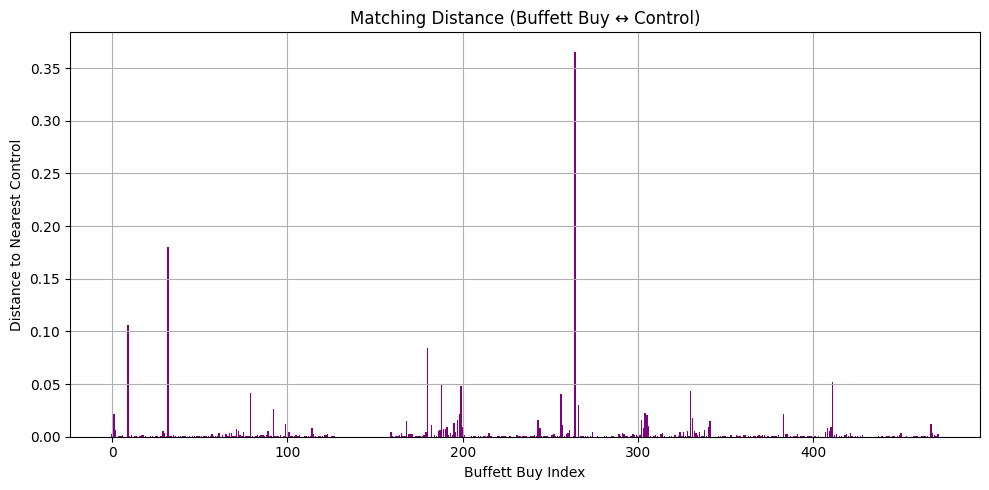

In [7]:
#  Visualize Match Distances
plt.figure(figsize=(10, 5))
plt.bar(range(len(distances)), distances.flatten(), color='purple')
plt.xlabel('Buffett Buy Index')
plt.ylabel('Distance to Nearest Control')
plt.title('Matching Distance (Buffett Buy ↔ Control)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
print("Distance Summary:\n", pd.Series(distances.flatten()).describe())

Distance Summary:
 count    472.000000
mean       0.003847
std        0.020519
min        0.000000
25%        0.000149
50%        0.000467
75%        0.001345
max        0.365736
dtype: float64


Combines the matched pairs into a single dataset and shuffles the rows.

In [9]:
# Combine Matched Pairs #----AP

matchedPairs = pd.concat([buffettBuys, matchedControls], axis=0).reset_index(drop=True)


In [10]:
#  Feature and Target Split #----AP
X = matchedPairs.drop(columns=['Label'])  # Drop label column
y = matchedPairs['Label']

Splits the data into features (X) and target (y).

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


import joblib

# # Save the data splits
# joblib.dump(X_train, 'C:/Users/amita/github/team_lambda/Data/X_train.pkl')
# joblib.dump(X_test, 'C:/Users/amita/github/team_lambda/Data/X_test.pkl')
# joblib.dump(y_train, 'C:/Users/amita/github/team_lambda/Data/y_train.pkl')
# joblib.dump(y_test, 'C:/Users/amita/github/team_lambda/Data/y_test.pkl')

In [12]:
# if apply_smote:
#     over = SMOTE(sampling_strategy=0.5, random_state=42)
#     under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
#     resample_pipeline = Pipeline(steps=[('o', over), ('u', under)])
#     X_train, y_train = resample_pipeline.fit_resample(X_train, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


c:\Users\amita\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:37:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Trains an XGBoost classifier on the training data

In [15]:
#  Predict & Evaluate 
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

In [14]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74        95
           1       0.74      0.68      0.71        94

    accuracy                           0.72       189
   macro avg       0.73      0.72      0.72       189
weighted avg       0.73      0.72      0.72       189

ROC AUC Score: 0.7990481522956328


In [16]:

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

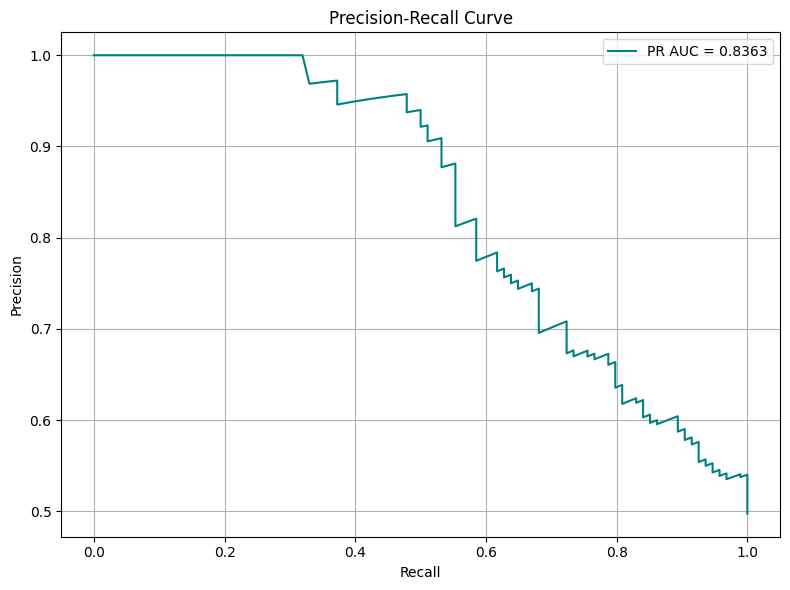

In [17]:
plt.figure(figsize=(8, 6)) 
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}', color='teal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 Threshold Optimization
 Optimizes the decision threshold based on the F1 score.

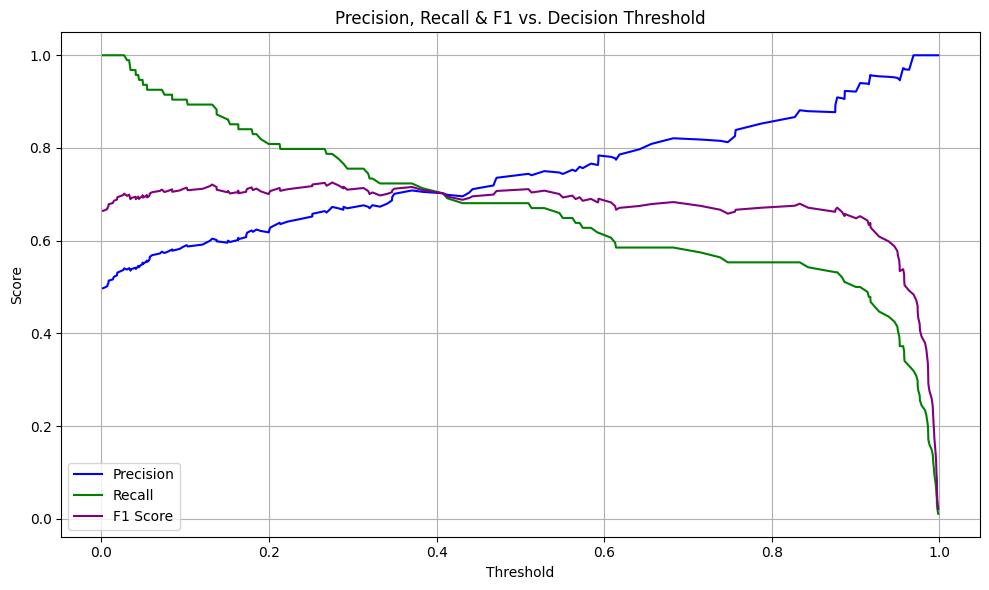

Best Threshold (Max F1): 0.28
Classification Report at Optimized Threshold:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        95
           1       0.67      0.79      0.73        94

    accuracy                           0.70       189
   macro avg       0.71      0.70      0.70       189
weighted avg       0.71      0.70      0.70       189



In [18]:
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for the positive class
y_probs = xgb.predict_proba(X_test)[:, 1]

# Precision-recall-threshold curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='purple')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1 vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold (Max F1): {best_threshold:.2f}")

# Apply new threshold
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# New classification report
from sklearn.metrics import classification_report
print("Classification Report at Optimized Threshold:")
print(classification_report(y_test, y_pred_adjusted))


The optimal threshold ensures a good balance between identifying "Buffett Buys" (recall) and minimizing false positives (precision).

 SHAP Interpretability

In [19]:
import shap

# Create explainer
explainer = shap.Explainer(xgb, X_train)

# Get SHAP values for the test set
shap_values = explainer(X_test)


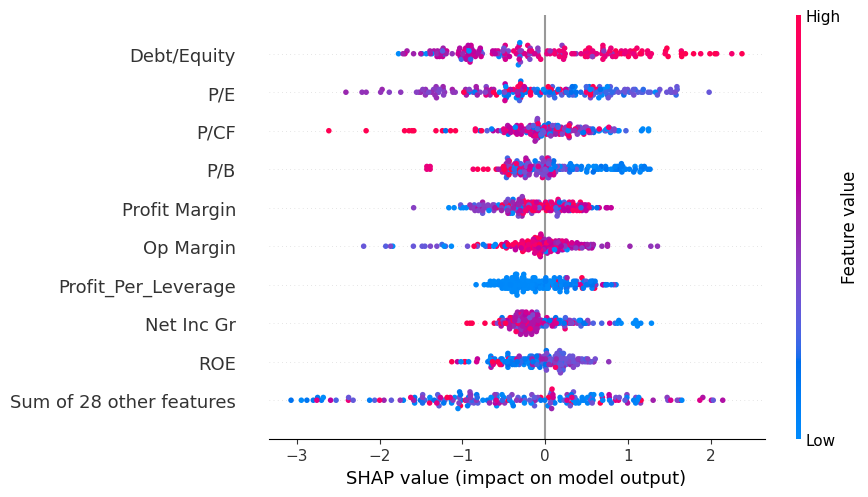

In [20]:
#Global feature importance plot
shap.plots.beeswarm(shap_values)


This SHAP beeswarm plot shows the impact of various features on the model's predictions. Features like Debt/Equity, P/E, and Profit Margin have the most significant influence, with red indicating high feature values and blue indicating low feature values.

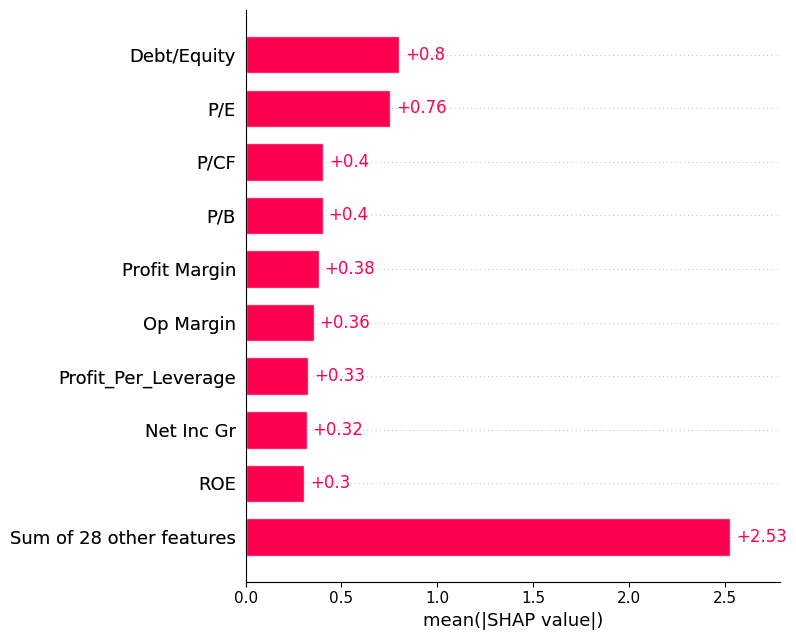

In [22]:
import matplotlib.pyplot as plt

# Summary bar plot
shap.plots.bar(shap_values, show=False)
plt.tight_layout()
plt.savefig("shap_summary_bar.png", dpi=300)
plt.show()


This SHAP summary bar plot shows the average impact of each feature on the model's predictions. Debt/Equity and P/E are the most influential features, with the highest mean SHAP values, indicating their strong contribution to the model's output. The "Sum of 28 other features" represents the combined impact of less significant features.

Hyperparameter Tuning  using randomized search.

In [23]:
#Hypertunning xg-boost

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, 
                                   n_iter=20, scoring='roc_auc', 
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Evaluate
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]
print("Tuned ROC AUC:", roc_auc_score(y_test, y_proba_best))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuned ROC AUC: 0.8158454647256438


c:\Users\amita\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [14:38:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The hyperparameter tuning process using randomized search has completed, evaluating 20 candidate models across 3 cross-validation folds (totaling 60 fits). The best model achieved a Tuned ROC AUC score of 0.8158, indicating its ability to distinguish between the positive (Buffett Buys) and negative (Controls) classes. This score reflects the model's improved performance after optimization.

In [ ]:
# Save pre-tuned models
# joblib.dump(xgb, 'C:/Users/amita/github/team_lambda/models/xgboost_pre_tuned.pkl')


['C:/Users/amita/github/team_lambda/models/xgboost_pre_tuned.pkl']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
joblib.dump(rf, 'C:/Users/amita/github/team_lambda/models/random_forest_pre_tuned.pkl')


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

joblib.dump(log_reg, 'C:/Users/amita/github/team_lambda/models/logistic_regression_pre_tuned.pkl')


c:\Users\amita\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [ ]:
#neural network

from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(random_state=42, max_iter=500)
nn_model.fit(X_train, y_train)
joblib.dump(nn_model, 'C:/Users/amita/github/team_lambda/models/neural_network_pre_tuned.pkl')

MLPClassifier(max_iter=500, random_state=42)